In [1]:
import scipy
import numpy as np

def random_rotation_matrix(numpy_random_state):
    """
    Generates a random 3D rotation matrix from axis and angle.

    Args:
        numpy_random_state: numpy random state object

    Returns:
        Random rotation matrix.
    """
    rng = numpy_random_state
    axis = rng.randn(3)
    axis /= np.linalg.norm(axis) + 1e-8
    theta = 2 * np.pi * rng.uniform(0.0, 1.0)
    return rotation_matrix(axis, theta)

def rotation_matrix(axis, theta):
    return scipy.linalg.expm(np.cross(np.eye(3), axis * theta))

In [2]:
import torch
from torch import nn

def get_eijk():
    """
    Constant Levi-Civita tensor

    Returns:
        torch.Tensor of shape [3, 3, 3]
    """
    eijk_ = torch.zeros((3, 3, 3))
    eijk_[0, 1, 2] = eijk_[1, 2, 0] = eijk_[2, 0, 1] = 1.
    eijk_[0, 2, 1] = eijk_[2, 1, 0] = eijk_[1, 0, 2] = -1.
    return torch.as_tensor(eijk_, dtype=torch.float32)


def difference_matrix(r: torch.Tensor) -> torch.Tensor:
    """
    r: (num_points, 3)
    Returns
    rij: (num_points, num_points, 3)
    """
    ri = torch.unsqueeze(r, 1)
    rj = torch.unsqueeze(r, 0)
    return ri - rj

def distance_matrix(rij):
    """
    rij: (num_points, num_points, 3)
    Returns
    dij: (num_points, num_points)
    """
    # [N, N]
    return torch.linalg.norm(rij, axis=-1)

class GetGeometry(nn.Module):
    def __init__(self,
                 rbf_low   = 0.0,
                 rbf_high  = 3.5,
                 rbf_count = 4):
        super().__init__()

        self.rbf_low     = rbf_low
        self.rbf_high    = rbf_high
        self.rbf_count   = rbf_count
        self.rbf_spacing = (self.rbf_high - self.rbf_low) / self.rbf_count

        # radial basis functions
        self.centers = torch.linspace(self.rbf_low, self.rbf_high, self.rbf_count)
        self.gamma = 1. / self.rbf_spacing

    def forward(self, r):
        
        r_ij = difference_matrix(r)            # [N, N, 3]
        d_ij = torch.linalg.norm(r_ij, dim=-1) # [N, N]
        rbf_ijk = torch.exp( -self.gamma * (d_ij.unsqueeze(-1) - self.centers)**2 ) # [N, N, rbf_count]

        return r_ij, rbf_ijk

class Radial(nn.Module):
    """Implements the learnable radial function"""

    def __init__(self, rbf_count, output_dim=1):
        super().__init__()
    
        self.R = nn.Sequential(
            nn.Linear(rbf_count, rbf_count),
            nn.ReLU(),
            nn.Linear(rbf_count, output_dim),
        )

        for param in self.R:
            if isinstance(param, nn.Linear):
                nn.init.orthogonal_(param.weight)
                nn.init.zeros_(param.bias)

    def forward(self, x):
        

        return self.R(x)
    
class Y_0(nn.Module):
    """Implements spherical harmonic of degree 0"""

    def __init__(self, N):
        super().__init__()

        self.out = torch.ones(N, N, 1) / (2 * (torch.pi)**0.5)

    def forward(self, x):
        return self.out

class Y_1(nn.Module):
    """Implements spherical harmonic of degree 1"""

    def __init__(self):
        super().__init__()
        self.factor = (3 / (4 * torch.pi))**0.5

    def forward(self, x):
        return nn.functional.normalize(x, dim=-1) * self.factor # Note the order is [m=1, m=-1, m=0]

class F_0(nn.Module):

    def __init__(self, N, rbf_count):
        super().__init__()

        self.R = Radial(rbf_count)
        self.Y = Y_0(N)

    def forward(self, x):
        r_ij, rbf_ijk, V = x
        return torch.einsum('ijc,ijm->ijcm', self.R(rbf_ijk), self.Y(r_ij))

class F_1(nn.Module):

    def __init__(self, N, rbf_count):
        super().__init__()

        self.R = Radial(rbf_count)
        self.Y = Y_1()

    def forward(self, x):
        r_ij, rbf_ijk, V = x
        radial = self.R(rbf_ijk)

        # Mask out radial
        d_ij = torch.linalg.norm(r_ij, dim=-1)
        radial[torch.where(d_ij < 1e-8)] = 0

        return torch.einsum('ijc,ijm->ijcm', radial, self.Y(r_ij))

class ConvolutionLayer(nn.Module):

    def __init__(self, N, rbf_count, l_in, l_filt, l_out):
        super().__init__()

        self.l_in = l_in
        self.l_filt = l_filt
        self.l_out = l_out

        # L x 0 -> L
        if l_filt == 0 and (l_in == l_out):
            self.F = F_0(N, rbf_count)
            self.cg = torch.eye(2*l_in+1).unsqueeze(-2)
        
        # 0 x 1 -> 0
        elif (((l_in == 0 and l_filt == 1) or (l_in == 1 and l_filt == 0)) and l_out == 0):
            raise ValueError(f"Cannot have {l_in} x {l_filt} -> {l_out}")
        
        # 0 x 1 -> 1
        elif l_in == 0 and l_filt == 1 and l_out == 1:
            self.F  = F_1(N, rbf_count)
            self.cg = torch.eye(3).unsqueeze(dim=-1)
        
        # 1 x 1 -> 0
        elif l_in == 1 and l_filt == 1 and l_out == 0:
            self.F = F_1(N, rbf_count)
            self.cg = torch.eye(3).unsqueeze(dim=0)

        # 1 x 1 -> 1
        elif l_in == 1 and l_filt == 1 and l_out == 1:
            self.F = F_1(N, rbf_count)
            self.cg = get_eijk()

        else:
            raise NotImplementedError(f"Not implemented for {l_in} x {l_filt} -> {l_out}")

    def forward(self, u):
        r_ij, rbf_ijk, V = u
        out = torch.einsum('ijk,abfj,bfk->afi', self.cg, self.F(u), V)
        return out

c000 = ConvolutionLayer(4, 4, 0, 0, 0) # 0 x 0 -> 0
c101 = ConvolutionLayer(4, 4, 1, 0, 1) # 1 x 0 -> 1
c011 = ConvolutionLayer(4, 4, 0, 1, 1) # 0 x 1 -> 1
c110 = ConvolutionLayer(4, 4, 1, 1, 0) # 1 x 1 -> 0
c111 = ConvolutionLayer(4, 4, 1, 1, 1) # 1 x 1 -> 1

geom = GetGeometry()

rng = np.random.RandomState()
rot = torch.Tensor(random_rotation_matrix(rng))

r_i = torch.randn(4, 3)
r_i_rot = r_i @ rot

r_ij, rbf_ijk = geom(r_i)
r_ij_rot, rbf_ijk_rot = geom(r_i_rot)

# Notes
# - when l=0, rotation corresponds to multiplication by a scalar (2l+1=0)
# - when l=1, rotation corresponds to multiplication by a matrix (2l+1=3)

# Equivariant tests for l_in = 0
V_acm = torch.ones(4, 1, 1)

torch.testing.assert_close(
    c000((r_ij, rbf_ijk, V_acm)),
    c000((r_ij_rot, rbf_ijk_rot, V_acm))
)

torch.testing.assert_close(
    c011((r_ij, rbf_ijk, V_acm)) @ rot,
    c011((r_ij_rot, rbf_ijk_rot, V_acm))
)

# Equivariant tests for l_in = 1
V_acm = torch.ones(4, 1, 3)
V_acm_rot = torch.einsum('acd,dm->acm', V_acm, rot)

torch.testing.assert_close(
    c101((r_ij, rbf_ijk, V_acm)) @ rot,
    c101((r_ij_rot, rbf_ijk_rot, V_acm_rot))
)

torch.testing.assert_close(
    c110((r_ij, rbf_ijk, V_acm)),
    c110((r_ij_rot, rbf_ijk_rot, V_acm_rot))
)

torch.testing.assert_close(
    c111((r_ij, rbf_ijk, V_acm)) @ rot,
    c111((r_ij_rot, rbf_ijk_rot, V_acm_rot))
)

In [3]:
# Equivariant Tensor Networks in PyTorch
# Implementation of the Tetris model described in (not https://arxiv.org/abs/2006.04851, as CoPilot suggested) but in fact https://arxiv.org/abs/1802.08219

import torch
import torch.nn as nn
from torch.nn.functional import softmax
        
class SelfInteraction(nn.Module):

    def __init__(self, 
                 in_features,
                 out_features,
                 embedding=False):
        super().__init__()

        # TODO: This seems a pretty hacky way to do things
        self.layers = nn.ModuleList([
            nn.Linear(in_features[0], out_features, bias=True),
            nn.Linear(in_features[1], out_features, bias=False) if not embedding else None
        ])
    
    def forward(self, u):
        # Want to sum over the channels

        _, _, input_layers = u

        # Testing
        # V_acm_test = torch.zeros_like(V_acm)
        # V_acm_test[:,:,:] = V_acm
        # out_test = torch.transpose(torch.einsum('afi,gf->aig', V_acm, self.layer.weight), 1, 2)

        output_layers = {}

        for k in input_layers:
            for V_acm in input_layers[k]:
                output_layers.setdefault(k, []).append(
                    torch.transpose(torch.einsum('afi,gf->aig', V_acm, self.layers[k].weight) + self.layers[k].bias, 1, 2) 
                        if self.layers[k].bias is not None else torch.transpose(torch.einsum('afi,gf->aig', V_acm, self.layers[k].weight), 1, 2)
                )

        return u[0], u[1], output_layers

class Convolution(nn.Module):
    # Input: dict(key=[l...], val=[tensors...])

    def __init__(self, N, rbf_count):
        super().__init__()

        self.conv_layers = {}
        
        for l_in in [0, 1]:
            self.conv_layers[l_in] = {}
            for l_filt in [0, 1]:
                self.conv_layers[l_in][l_filt] = {}
                for l_out in [0, 1]:
                    if (l_in, l_filt, l_out) in [(0, 1, 0), (1, 0, 0), (0, 0, 1)]: continue
                    self.conv_layers[l_in][l_filt][l_out] = ConvolutionLayer(N, rbf_count, l_in, l_filt, l_out)

    def forward(self, u):
        r_ij, rbf_ijk, input_layers = u

        output_layers = {0:[], 1:[]}
        for l_in in input_layers:
            for l_filt in [0, 1]:
                for l_out in output_layers:

                    if (l_in, l_filt, l_out) in [(0, 1, 0), (1, 0, 0), (0, 0, 1)]: continue

                    x = self.conv_layers[l_in][l_filt][l_out]((r_ij, rbf_ijk, input_layers[l_in][0]))
                    output_layers[l_out].append(x)

        return u[0], u[1], output_layers

class Concatenate(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, u):
        _, _, input_layers = u
        output_layers = {}
        for k in input_layers:
            output_layers[k] = [torch.concatenate(input_layers[k], dim=-2)]
        return u[0], u[1], output_layers

class NonLinearity(nn.Module):

    def __init__(self, input_channels):
        super().__init__()

        self.elu  = nn.ELU()
        self.bias = nn.Parameter(torch.zeros(input_channels))


    def forward(self, u):
        _, _, input_layers = u
        output_layers = {}
        for k in input_layers:
            if k == 0:
                output_layers[k] = [self.elu(input_layers[k][0])]
            elif k == 1:
                output_layers[k] = [self.elu(torch.linalg.norm(input_layers[k][0], dim=-1).unsqueeze(-1) + self.bias.reshape(1, -1, 1)) * input_layers[k][0]]

        return u[0], u[1], output_layers


class EQN(nn.Module):

    def __init__(self, 
                 N=4,
                 rbf_count=4, 
                 rbf_low=0.0, 
                 rbf_high=3.5,
                 input_channels=1, 
                 layer_dims=[1, 4, 4, 4]):
        super().__init__()

        self.get_geom  = GetGeometry(rbf_low, rbf_high, rbf_count)
        self.embedding = SelfInteraction((input_channels, input_channels), 1, embedding=True)

        self.layers = nn.Sequential()

        for layer, layer_dim in enumerate(layer_dims[1:]):
            self.layers.append(Convolution(N, rbf_count))
            self.layers.append(Concatenate())
            self.layers.append(SelfInteraction(([2, 8, 8][layer], [2, 12, 12][layer]), layer_dim))
            self.layers.append(NonLinearity(layer_dim))

        self.output_layer = nn.Linear(4, 8)

    def forward(self, r_i, x):
        
        r_ij, rbf_ijk = self.get_geom(r_i)
        x = self.embedding((r_ij, rbf_ijk, x))
        _, _, x = self.layers(x)

        # print(x[0][0].shape)

        x = torch.mean(x[0][0].squeeze(), dim=0)
        x = self.output_layer(x)

        return x
    
    def pred(self, r_i, x):
        return softmax(self.forward(r_i, x))



Epoch: 0 Loss: 2.103


/var/folders/hj/l947w2kj47v3cl_f2yb2twhh0000gn/T/ipykernel_27149/2912339478.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  dataset = torch.Tensor(dataset)
/var/folders/hj/l947w2kj47v3cl_f2yb2twhh0000gn/T/ipykernel_27149/2912339478.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.imshow(softmax(pred).detach().numpy())


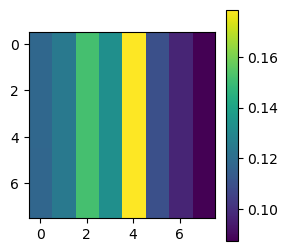

Epoch: 200 Loss: 1.037


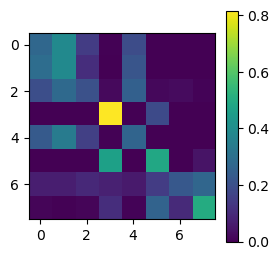

Epoch: 400 Loss: 0.444


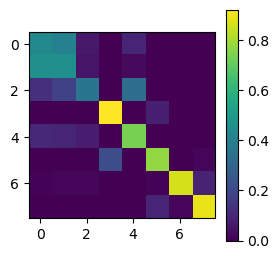

Epoch: 600 Loss: 0.067


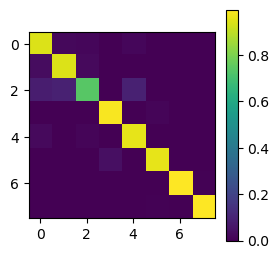

Epoch: 800 Loss: 0.011


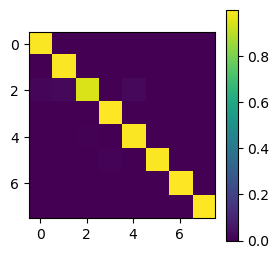

Epoch: 1000 Loss: 0.003


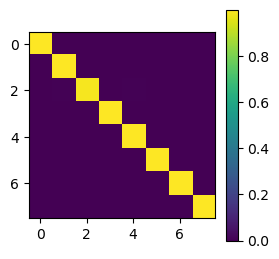

Final Loss: 2.5828e-03


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

tetris = [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 1, 0)],  # chiral_shape_1
          [(0, 0, 0), (0, 0, 1), (1, 0, 0), (1, -1, 0)], # chiral_shape_2
          [(0, 0, 0), (1, 0, 0), (0, 1, 0), (1, 1, 0)],  # square
          [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3)],  # line
          [(0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0)],  # corner
          [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0)],  # T
          [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 1)],  # zigzag
          [(0, 0, 0), (1, 0, 0), (1, 1, 0), (2, 1, 0)]]  # L

dataset = [np.array(points_) for points_ in tetris]
num_classes = len(dataset)
dataset = torch.Tensor(dataset)
labels = torch.nn.functional.one_hot(torch.arange(8),num_classes=8).to(torch.float32)

def initialize(module):
    for l in module.layers:
        if hasattr(l, 'layers'):
            initialize(l)
        if isinstance(l, nn.Linear):
            nn.init.orthogonal_(l.weight)
            if l.bias is not None:
                nn.init.zeros_(l.bias)

def train(model: nn.Module, loss_fn, optimizer, epochs=100):

    model.train()

    for i in range(epochs):
        for j in range(dataset.shape[0]):
            pred = model(dataset[j], {0:[V_acm]})
            loss = loss_fn(pred, labels[j])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if i%200 == 0:
            model.eval()
            pred = torch.zeros_like(labels)
            for j in range(dataset.shape[0]):
                pred[j] = model(dataset[j], {0:[V_acm]})
            loss = loss_fn(pred, labels)
            print(f"Epoch: {i} Loss: {loss:.3f}")
            plt.figure(figsize=(3, 3))
            plt.imshow(softmax(pred).detach().numpy())
            plt.colorbar()
            plt.show()
            model.train()

model = EQN()

initialize(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model, loss_fn, optimizer, epochs=1001)
model.eval()

pred = torch.zeros_like(labels)
for j in range(dataset.shape[0]):
    pred[j] = model(dataset[j], {0:[V_acm]})

loss = loss_fn(pred, labels)
print(f"Final Loss: {loss.item():.4e}")

In [5]:
rng = np.random.RandomState(42)

true_pos = 0
total = 0
for j in range(25):
    for i in range(len(dataset)):
        rotated = dataset[i] @ torch.Tensor(random_rotation_matrix(rng))
        true_pos += model.pred(rotated, {0:[V_acm]}).argmax().detach().numpy() == i
        total += 1

print(f"Accuracy: {true_pos / total * 100}%")

/var/folders/hj/l947w2kj47v3cl_f2yb2twhh0000gn/T/ipykernel_27149/450010468.py:145: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return softmax(self.forward(r_i, x))


Accuracy: 100.0%


/var/folders/hj/l947w2kj47v3cl_f2yb2twhh0000gn/T/ipykernel_27149/450010468.py:145: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return softmax(self.forward(r_i, x))


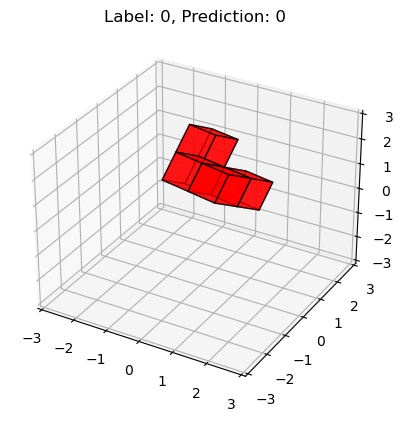

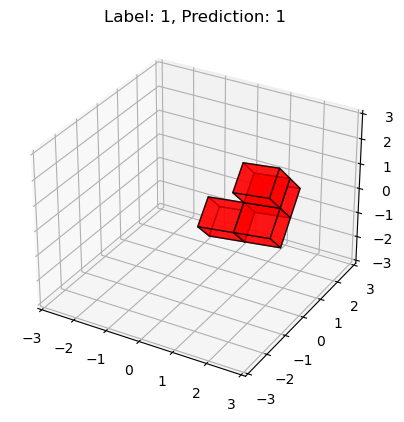

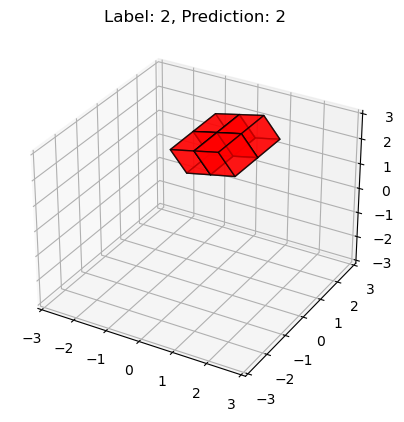

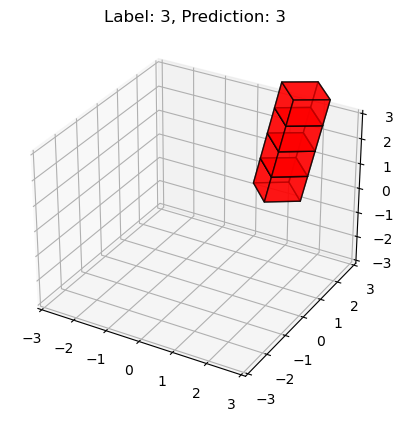

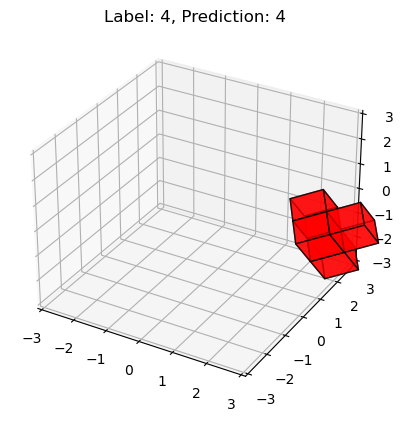

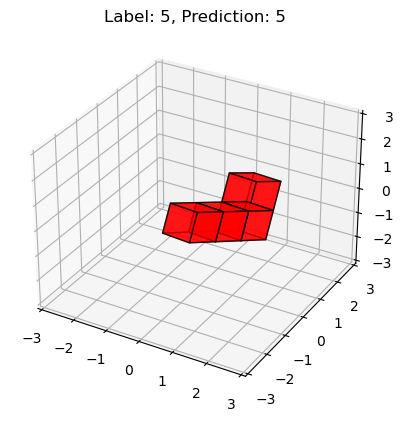

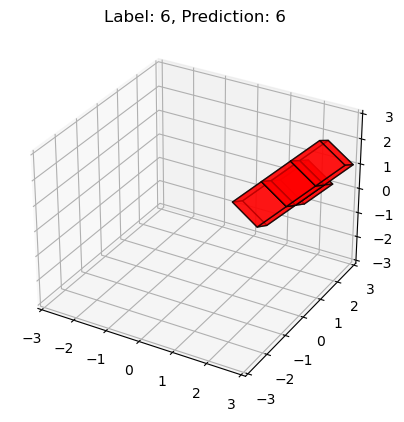

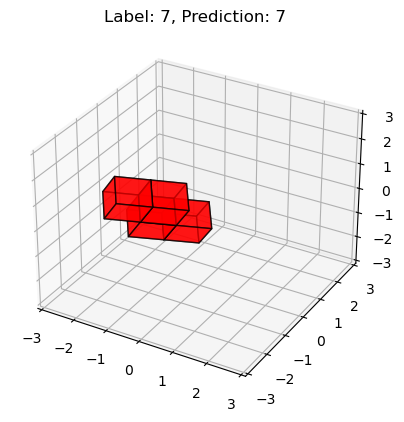

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d_cube(ax, position, translation, rotation, size=1, color='blue'):
    cube_vertices = np.array([
        [0, 0, 0],
        [0, 1, 0],
        [1, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 1],
        [1, 1, 1],
        [1, 0, 1]
    ])
    
    cube_vertices = size * cube_vertices @ rotation + np.array(position) @ rotation + translation
    
    cube_faces = [
        [0, 1, 2, 3],
        [4, 5, 6, 7],
        [0, 1, 5, 4],
        [2, 3, 7, 6],
        [1, 2, 6, 5],
        [0, 3, 7, 4]
    ]
    
    poly = Poly3DCollection(cube_vertices[cube_faces], alpha=0.7)
    poly.set_facecolor(color)
    poly.set_edgecolor('black')
    poly.set_linestyle('solid')
    poly.set_linewidth(1)
    ax.add_collection3d(poly)

for i in range(len(dataset)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    rot = random_rotation_matrix(rng)
    trans = rng.uniform(-2.0, 2.0, 3)
    for pos in dataset[i]:
        plot_3d_cube(ax, position=pos, translation=trans, rotation=rot, size=1, color='red')

    r_i = dataset[i] @ torch.Tensor(rot) + torch.Tensor(trans)
    pred = model.pred(r_i, {0:[V_acm]}).argmax()
    plt.title(f"Label: {i}, Prediction: {pred}")
    # plot_3d_cube(ax, position=(1, 1, 0), size=1, color='green')
    # plot_3d_cube(ax, position=(0, 1, 1), size=1, color='blue')

    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])

plt.show()